In [132]:
# COMMON LIBRARIES
import os
import cv2
import requests
import json
import numpy as np
import torch
import random

import matplotlib.pyplot as plt
from datetime import datetime

from scipy.spatial import distance
from scipy.interpolate import interp1d

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# Percorsi ai file COCO
base_path = os.getcwd()

# Costruisci i percorsi relativi alla posizione dello script
json_file = os.path.join(base_path, "../../annotations", "instances_val2017.json")
image_folder = os.path.join(base_path, "../../val2017/")

# Nome dell'immagine di cui trovare la bounding box
image_filenames = "000000409475.jpg"

#Modello pre-addestrato
MODEL_USED = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"



In [133]:
def extract_pixels_from_coco(image_filename, json_file):
    # 1. Caricare il file JSON con le annotazioni
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # 2. Creare una mappatura tra category_id e category_name
    category_dict = {category["id"]: category["name"] for category in coco_data["categories"]}

    # 3. Trovare i dati dell'immagine corrispondente al nome file
    image_data = next((img for img in coco_data["images"] if img["file_name"] == image_filename), None)

    if image_data is None:
        print("Immagine non trovata nel dataset COCO!")
        return []

    image_id = image_data["id"]
    image_width = image_data["width"]
    image_height = image_data["height"]

    # 4. Estrarre le segmentazioni associate a questa immagine
    extracted_data = []
    for ann in coco_data["annotations"]:
        if ann["image_id"] == image_id:
            category_id = ann["category_id"]
            category_name = category_dict.get(category_id, "Unknown")

            # Converte le segmentazioni in array di interi (ogni istanza può avere più poligoni)
            segmentation_pixels = [np.array(seg, dtype=np.int32).reshape((-1, 2)).tolist() for seg in ann["segmentation"]]

            extracted_data.append({
                "category_name": category_name,
                "pixels": segmentation_pixels,
                "image_width": image_width,
                "image_height": image_height
            })

    return extracted_data


def scale_image(folder_image, name_file):
    # Carica l'immagine in scala di grigi (o a colori)
    image = cv2.imread(folder_image+name_file)

    # Converti in float per evitare problemi con interi
    image = image.astype(np.float32)

    # Trova il valore massimo
    max_value = np.max(image)

    # Evita divisioni per zero
    if max_value > 0:
        image_scaled = image / max_value
    else:
        image_scaled = image  # Evita errori se l'immagine è completamente nera

    return image_scaled

def scale_polygon(polygon, image_width, image_height):
    """
    Scala le coordinate dei punti del poligono tra [0,1].
    
    Args:
        polygon (list): Lista di punti [(x1, y1), (x2, y2), ...]
        image_width (int): Larghezza dell'immagine
        image_height (int): Altezza dell'immagine
    
    Returns:
        list: Poligono con coordinate scalate tra [0,1]
    """
    return [(x / image_width, y / image_height) for x, y in polygon]


def process_detectron2_output(image_filename, model_used):
    # 1. Caricare l'immagine
    image = cv2.imread(image_filename)
    
    # 2. Configurare il modello pre-addestrato di Detectron2
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_used))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Imposta la soglia di confidenza
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_used)
    cfg.MODEL.DEVICE = "cpu"  # Usa la CPU (puoi cambiare con 'cuda' se hai una GPU)
    
    # 3. Inizializzare il predittore
    predictor = DefaultPredictor(cfg)
    
    # 4. Eseguire il modello sull'immagine
    outputs = predictor(image)

    # 5. Estrarre le istanze predette (classi, bounding boxes)
    instances = outputs["instances"].to("cpu")
    
    # 6. Ottenere il metadata (nomi delle classi)
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    
    # 7. Estrazione delle informazioni delle classi, bounding boxes e maschere
    category_ids = instances.pred_classes.numpy()  # ID delle classi
    bboxes = instances.pred_boxes.tensor.numpy()  # Bounding boxes
    masks = outputs["instances"].pred_masks.cpu().numpy()  # Shape: (N, H, W) (N=numero di istanze)
    
    # 8. Creare un array delle istanze predette con le informazioni desiderate
    boxes_predected = []
    
    for category_id, bbox, pred_mask in zip(category_ids, bboxes, masks):
        category_name = metadata.thing_classes[category_id]  # Ottieni il nome della categoria
        # Converti la maschera binaria in formato uint8
        mask_uint8 = (pred_mask * 255).astype(np.uint8)

        # Trova i contorni
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Converte i contorni in segmentazioni poligonali
        for contour in contours:
            if len(contour) > 2:  # Serve almeno un triangolo
                polygon = contour.reshape(-1, 2).tolist()  # Converte in lista di tuple [(x1,y1), (x2,y2), ...]
        
        # Aggiungi l'istanza al risultato
        boxes_predected.append({
            "category_name": category_name,
            "pixels": polygon,
            "image_width": image.shape[1],
            "image_height": image.shape[0]
        })

    return boxes_predected

def interpolate_pixels(pixel_array, num_points=100):
    pixel_array = np.array(pixel_array)
    x, y = pixel_array[:, 0], pixel_array[:, 1]
    
    # Creazione della spline
    tck, u = splprep([x, y], s=0, k=1)
    
    # Generazione di nuovi punti interpolati
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    
    return np.column_stack((x_new, y_new))




In [134]:

gt = extract_pixels_from_coco(image_filenames, json_file)
pred_points = process_detectron2_output(image_folder+image_filenames, MODEL_USED)

print(gt[0]["pixels"][0])
print(pred_points[0]["pixels"])
gt_interpoled = interpolate_pixels(gt[0]["pixels"][0], max(len(gt[0]["pixels"][0]),len(pred_points[0]["pixels"])))

gt_interpoled_01 = scale_polygon(gt_interpoled, gt[0]["image_width"],gt[0]["image_height"])
pred_points_01 = scale_polygon(pred_points[0]["pixels"],pred_points[0]["image_width"],pred_points[0]["image_height"])
print("GT interpolata su scala [0,1]:\n",gt_interpoled_01)
print("Predected su scala [0,1]:\n",pred_points_01)

[[148, 447], [168, 409], [173, 396], [173, 378], [161, 356], [156, 318], [156, 299], [138, 283], [145, 243], [155, 219], [169, 207], [175, 192], [170, 190], [165, 172], [166, 157], [180, 148], [189, 141], [203, 141], [218, 149], [224, 169], [218, 185], [245, 192], [239, 210], [248, 218], [247, 263], [285, 285], [297, 289], [300, 312], [290, 314], [273, 313], [229, 279], [235, 364], [224, 465], [220, 470], [162, 474], [127, 470]]
[[191, 143], [190, 144], [189, 144], [188, 145], [186, 145], [184, 147], [183, 147], [182, 148], [180, 148], [179, 149], [176, 149], [175, 150], [174, 150], [172, 152], [172, 153], [171, 154], [171, 155], [170, 156], [170, 158], [169, 159], [169, 160], [168, 161], [168, 163], [167, 164], [167, 171], [168, 172], [168, 174], [169, 175], [169, 176], [170, 177], [170, 180], [171, 181], [171, 185], [172, 186], [172, 189], [173, 190], [173, 193], [172, 194], [172, 195], [171, 196], [171, 198], [170, 199], [170, 200], [169, 201], [169, 202], [168, 203], [168, 204], [1

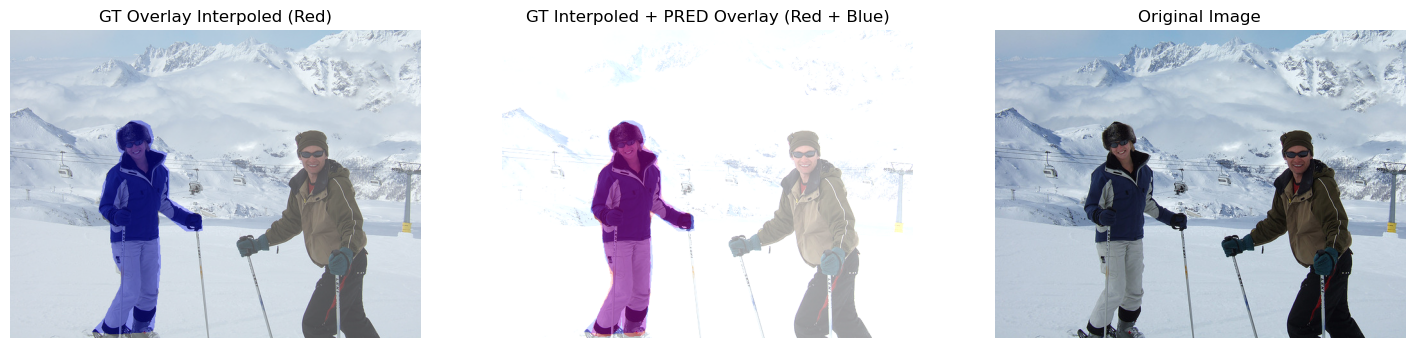

In [135]:
image = cv2.imread(image_folder+image_filenames)
# Crea le maschere vuote per GT e PRED
img_gt = np.ones_like(image) * 255  # Immagine bianca per GT
img_pred = np.ones_like(image) * 255  # Immagine bianca per PRED

# Disegna i poligoni sui canvas delle maschere (usando gli array gt_interpoled e pred_points)
gt_interpoled_255= np.array(gt_interpoled, dtype=np.int32)  # Assicurati che siano in formato corretto
pred_points_255 = np.array(pred_points[0]["pixels"], dtype=np.int32)

# Riempie il poligono GT con il colore rosso vivace (255, 0, 0)
cv2.fillPoly(img_gt, [gt_interpoled_255], (255, 0, 0))

# Riempie il poligono PRED con il colore blu vivace (0, 0, 255)
cv2.fillPoly(img_pred, [pred_points_255], (0, 0, 255))

# Sovrapponi le maschere sull'immagine originale con maggiore opacità
overlay_gt = cv2.addWeighted(image, 0.7, img_gt, 0.3, 0)  # Aumenta l'opacità della maschera GT
overlay_pred = cv2.addWeighted(overlay_gt, 1, img_pred, 0.3, 0)  # Sovrapponi anche la maschera PRED

# Imposta la dimensione della figura
plt.figure(figsize=(18, 6))

# Mostra l'immagine originale con la maschera GT sovrapposta
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(overlay_gt, cv2.COLOR_BGR2RGB))
plt.title("GT Overlay Interpoled (Red)")
plt.axis('off')

# Mostra l'immagine originale con la maschera PRED sovrapposta
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(overlay_pred, cv2.COLOR_BGR2RGB))
plt.title("GT Interpoled + PRED Overlay (Red + Blue)")
plt.axis('off')

# Mostra l'immagine originale senza maschera
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Mostra le immagini affiancate
plt.show()

In [136]:
def calculate_rmse(gt_points, pred_points):
    gt_points = np.array(gt_points, dtype=np.float32)
    pred_points = np.array(pred_points, dtype=np.float32)
    
    # Calcola RMSE
    rmse = np.sqrt(np.mean((gt_points - pred_points) ** 2))
    
    # Calcola la media delle coordinate dei punti GT
    mean_gt = np.mean(gt_points)
    
    # Calcola la percentuale rispetto alla media dei valori GT
    rmse_percentage = (rmse / mean_gt) * 100 if mean_gt != 0 else 0
    
    return rmse, rmse_percentage

rmse, rmse_percent = calculate_rmse(gt_interpoled_01,pred_points_01)
print("ERRORE: ", rmse, ", in percentuale:",rmse_percent,"%")

ERRORE:  0.29771784 , in percentuale: 61.86215281486511 %


In [137]:
def calculate_rmse_under_mask(image, gt_mask, pred_mask):
    """
    Calcola il Root Mean Square Error (RMSE) tra i pixel dell'immagine sotto le due maschere.
    """
    # Estrai i pixel dell'immagine sotto la maschera GT
    gt_pixels = image[gt_mask > 0]
    pred_pixels = image[pred_mask > 0]

    if len(gt_pixels) == 0 or len(pred_pixels) == 0:
        print("ERRORE: Una delle due maschere non copre alcun pixel!")
        return np.nan

    # Assicuriamoci che abbiano lo stesso numero di pixel
    min_pixels = min(len(gt_pixels), len(pred_pixels))
    gt_pixels = gt_pixels[:min_pixels]
    pred_pixels = pred_pixels[:min_pixels]

    # Calcola il RMSE
    rmse = np.sqrt(np.mean((gt_pixels.astype(np.float32) - pred_pixels.astype(np.float32)) ** 2))
    
    return rmse

# Creare maschere vuote della stessa dimensione dell'immagine
gt_mask = np.zeros(image.shape[:2], dtype=np.uint8)
pred_mask = np.zeros(image.shape[:2], dtype=np.uint8)
# Convertire i poligoni in maschere
cv2.fillPoly(gt_mask, [np.array(gt_interpoled_255, dtype=np.int32)], 255)
cv2.fillPoly(pred_mask, [np.array(pred_points_255, dtype=np.int32)], 255)
# Calcolare l'errore RMSE tra i pixel sotto le due maschere
error_rmse = calculate_rmse_under_mask(image, gt_mask, pred_mask)

print(f"Errore RMSE tra i pixel sotto le maschere con valori tra [0,255]: {error_rmse}")

# Normalizzare l'immagine tra [0,1]
image_01 = image.astype(np.float32) / 255.0  

# Creare maschere vuote
gt_mask_01 = np.zeros(image_01.shape[:2], dtype=np.float32)
pred_mask_01 = np.zeros(image_01.shape[:2], dtype=np.float32)

# Ottenere altezza e larghezza dell'immagine
height, width = image_01.shape[:2]

# Riempire le maschere
cv2.fillPoly(gt_mask_01, [gt_interpoled_255], 1)
cv2.fillPoly(pred_mask_01, [pred_points_255], 1)


# Calcolare l'errore RMSE tra i pixel sotto le due maschere
error_rmse_01 = calculate_rmse_under_mask(image_01, gt_mask_01, pred_mask_01)

print(f"Errore RMSE tra i pixel sotto le maschere con valori tra [0,1]: {error_rmse_01}")


Errore RMSE tra i pixel sotto le maschere con valori tra [0,255]: 67.4588851928711
Errore RMSE tra i pixel sotto le maschere con valori tra [0,1]: 0.26454463601112366
